# Generating Text with an RNN

In [ ]:
import unidecode
import string
import random
import re 
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [ ]:
from rnnn.model import RNN
from rnnn.helpers import time_since
from rnnn.generate import generate

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [ ]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = './shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 4573338
train len:  4116004
test len:  457334


In [ ]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

 protest,
Maugre thy strength, youth, place, and eminence,
Despite thy victor sword and fire-new fortune,
Thy valour and thy heart, thou art a traitor;
False to thy gods, thy brother, and thy father;
C


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [ ]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [ ]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [ ]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Train RNN

In [ ]:
batch_size = 100
n_epochs = 5000
hidden_size = 100
n_layers = 1
learning_rate = 0.01
model_type = 'rnn'
print_every = 50
plot_every = 50


In [ ]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [ ]:
def train(rnn, input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    loss = None
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    hidden = rnn.init_hidden(batch_size, device=device)
    rnn.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = rnn(input[:,c],hidden)
        loss += criterion(output, target[:,c])
    loss = loss / chunk_len

    loss.backward()
    optimizer.step()
    
    ##########       END      ##########

    return loss/ chunk_len


In [ ]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)  #lr=0.001
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 5000 epochs...
 34s (50 1%) train loss: 3.0023, test_loss: 2.9911]
Wh1VUzH	
HcVkr Cesir
A
t Ve ithro wy cshsaacne porotirl:R e mawaoweue  t lot aahklTok hade thhre ach  

 8s (100 2%) train loss: 2.6042, test_loss: 2.6055]
Wheors linr lous cEe

alisMhe lefud cn Iass ny for tor warou wumed fo athe n merw.
Munt

s! buhit bios 

 43s (150 3%) train loss: 2.4102, test_loss: 2.4043]
Whf! Ir
 ad bameag s,uwnd thing cage wit oft thanfr, toull ak tho ofr n whof angouns tot the thoursthe 

 17s (200 4%) train loss: 2.2972, test_loss: 2.3034]
Wh me proasan:
Aond ful sath.

DRYTILUGEART:
sle theruse'sd thicent.

Hom he.

GONTRRAOK:
Aund man gha 

 52s (250 5%) train loss: 2.2038, test_loss: 2.2119]
Whon hing peod of the comigh her mos in and and bece be scoes looud, co gero lom buer reress gour thar 

 26s (300 6%) train loss: 2.1548, test_loss: 2.1668]
Whard that perten; Hand hor that way lor mome; his is oun rere be to! shat to ar arthaing to were:
Wol 

 1s (350 7%) train loss: 2

In [ ]:
# save network
# torch.save(classifier.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

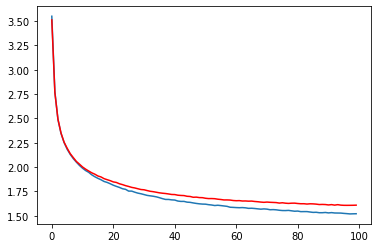

In [ ]:
import matplotlib.pyplot as plt #lr = 0.001
import matplotlib.ticker as ticker
import numpy as np

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

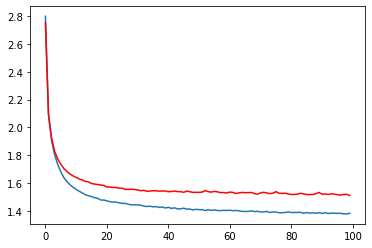

In [ ]:
import matplotlib.pyplot as plt   #rnn layer =2
import matplotlib.ticker as ticker
import numpy as np

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

In [ ]:
import matplotlib.pyplot as plt #hidden size 200
import matplotlib.ticker as ticker
import numpy as np

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [ ]:
print(evaluate(rnn, prime_str='Th', predict_len=1000)) # lr=0.001

The king a many on fortune and recun,
In in the company me so manisce,
Like hast knew the hustience in this?

Messenger:
Madam?

HORATIO:
O the present my couptening such oath thee,
Come to sayest you seement has fool,
For the would in the gentrerful warrant play
which mine, and in sub; and worth no men,--

SHIRON:
What it had still we missed expeither to read,
Of are and wear me for acquains the excellister not,
And till the Duke and accomsagies the life;
Little wood to of the man with all the went of liqus was him for
Which of yours: when she have marrions eat
That speat that these to a noed with my swear thire,
Whose cannot extrele found kis to disence
That their can the sword and a purden honests,
Ay way mother to the paderate with me!

LUCENTIUS:

DON ADRIANO DE OF YORK:
When they know yet a care.

OTHELLO:
What in my sight; or mords.

PANTHANUS:
Recons a nowal for the creature.

Second Senequing:
Sind, you have lion: he hight again not? and I lady
Doubt it thou shall not since in

In [ ]:
print(evaluate(rnn, prime_str='Th', predict_len=1000)) #rnn layer=2

Then for the offence, which with at our cartive
And shall I come delights than the temmed and let
the foot of the place of no madomar, sanchest acquess
weep the munder to come plink it busy
videry of the Caid forward.

PRINCE HENRY:
No, he will be not my wore the point say I
then too man the man all the fair long hold her, by my name,
And from her begined have her so marry with her
which not that rich one enate is the Emore's mind,
Wouldst Greek my world my sword, and see it.

BOTTITUS:
Why would see hurthing in his eyes and choose,
To be gross the palling but to speak them:
That you hear signor, or abrear! and in thy brother hast
the be in this lord, and say a wombing of her will obedies,
Parthed me better sorrow! unly our love with the fearful
for her noble thy head you main we would bender.

CORNEM:
How shall'st thy dear an his mock in thee.

PANDARUS:
My lord; nor blessing many shall o'erthy comes me, the still drender.

PRINCE HENRY:
Well slander upon the state.

PANDARUS:
What is

In [ ]:
print(evaluate(rnn, prime_str='Th', predict_len=1000)) # hidden size 200

The name with our Roman callen safe as ever
one of thee to mare the prince comfort,
I'll make with my throat his body;
Where repent your stomach to the weaknireward, and come
as well then child the war is lord, my lord.

KING RICHARD III:
Let her ripe of the charged: but let me stay.

VALENTINE:
What should he stay, Lord Her own bore,
The maidens, and one of wine of all
From one of his cold much off come:
Therefore death, after his injured,
That I have fly the precious snart
And some forward courtesy of his power
Than of father, the world no return and the man,
I tell you gone too, the word, thou dost thou dares
sins forth most recomfortenance or in the cast of the
splitrious love to march and minute are a troubles.

KING CLAUDIUS:
While I came and I have renowning troop
Whithen get it in day to come to be these.

DUMAIN:
I will say are you a goodly queen
To be so ill, which not I come.

Posbraint:
He did you not ready them deeper, skip up in
Count or talk.

MISTRESS PAGE:
Ne here.

Fi

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.

In [ ]:
# included in the report